### Load Libraries

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from collections import Counter
from imblearn.datasets import make_imbalance
import sklearn.cluster as cluster

In [50]:
#load the data
df = pd.read_csv('wine.csv')
# to visualize all the columns at once.
#pd.set_option('display.max_columns', None)

In [51]:
#fetch first five rows
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


### Summary of dataset features
- Total instances - 1599
- Total columns - 12

### Data Pre-Processing

In [53]:
# now lets check for missing values
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values

quality                 0
alcohol                 0
sulphates               0
pH                      0
density                 0
total sulfur dioxide    0
free sulfur dioxide     0
chlorides               0
residual sugar          0
citric acid             0
volatile acidity        0
fixed acidity           0
dtype: int64

In [54]:
df['quality'].replace({'good' : 1, 'bad' :0}, inplace = True)

In [55]:
df.duplicated().sum()

240

In [56]:
df.drop_duplicates(inplace = True)

### Pre-Processing Summary
- Surprisingly this is a clean data and consequently left with no null values and 
- 240 duplicated instances has been dropped as it doesn't contribite much to the target feature

### Univariate analysis for target feature

In [57]:
df['quality'].value_counts()

1    719
0    640
Name: quality, dtype: int64

In [58]:
class_0, class_1 = df['quality'].value_counts(normalize = True)
print(f'Class 0 before imbalance:', round(class_0 *100,1) ,'%')
print(f'Class 1 before imbalance:', round(class_1 *100,1) ,'%')

Class 0 before imbalance: 52.9 %
Class 1 before imbalance: 47.1 %


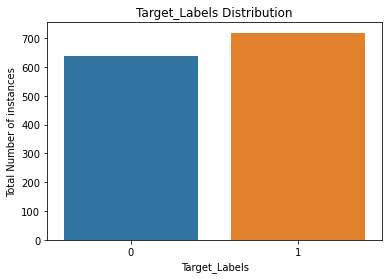

In [59]:
sns.countplot(x = 'quality', data = df)
plt.title('Target_Labels Distribution')
plt.xlabel('Target_Labels')
plt.ylabel('Total Number of instances')
plt.savefig('Target_Labels Distributions.jpg')

### Ensuring balance of dataset

In [60]:
df['quality'].value_counts()

1    719
0    640
Name: quality, dtype: int64

In [61]:
good = df[df['quality'] == 1]
bad = df[df['quality'] == 0]

In [62]:
from sklearn.utils import resample
good_downsample = resample(good,
             replace=True,
             n_samples=len(bad),
             random_state=42)

In [63]:
df = pd.concat([good_downsample, bad])
df['quality'].value_counts()

1    640
0    640
Name: quality, dtype: int64

Text(0, 0.5, 'Total Number of instances')

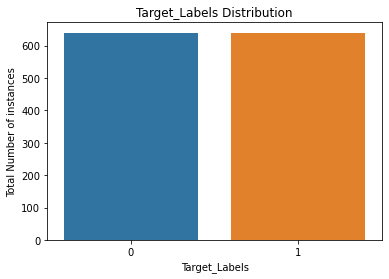

In [64]:
sns.countplot(x = 'quality', data = df)
plt.title('Target_Labels Distribution')
plt.xlabel('Target_Labels')
plt.ylabel('Total Number of instances')

### Imbalancing the target feature
- As mentioned in the project small imbalances of one class is fine, I'll proceed with further step 'making the target feature imbalance'

In [65]:
X = df.loc[:, df.columns != 'quality']
y = df.loc[:,'quality'].copy() # lets work with the copy without disturbing the original target feature

In [66]:
X.shape, y.shape

((1280, 11), (1280,))

In [67]:
# 65% imbalance
X_65, y_65 = make_imbalance(X, y, sampling_strategy={0:224 , 1: 416}, random_state=48)
print(f'Distribution after imbalancing: {Counter(y_65)}')

Distribution after imbalancing: Counter({1: 416, 0: 224})


In [68]:
class0 , class1 = y_65.value_counts(normalize = True)
print(f'Class 0 after imbalance:', round(class0 *100,1) ,'%')
print(f'Class 1 after imbalance:', round(class1 *100,1) ,'%')

Class 0 after imbalance: 65.0 %
Class 1 after imbalance: 35.0 %


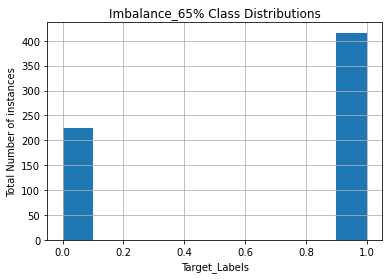

In [69]:
# 65% imbalance target feature
y_65.hist() 
plt.title('Imbalance_65% Class Distributions')
plt.xlabel('Target_Labels')
plt.ylabel('Total Number of instances')
plt.savefig('Imbalance_65% Class Distributions.jpg')

In [70]:
X_65.shape, y_65.shape

((640, 11), (640,))

## Stratified KFold

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [72]:
skf = StratifiedKFold(n_splits=10, random_state = None)
rf_clf = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42) #rf model

In [73]:
#Training with 65% imbalance surrogate
skf.get_n_splits(X_65, y_65)
score = []
precision = []
recall = []
for train_index, test_index in skf.split(X_65, y_65):
    #print('Train:' , train_index, 'Validation: ', test_index)
    x_train, x_test = X_65.iloc[train_index], X_65.iloc[test_index]
    y_train, y_test = y_65.iloc[train_index], y_65.iloc[test_index]
    rf_clf.fit(x_train, y_train)
    acc = accuracy_score(y_test, rf_clf.predict(x_test))
    precision_s = precision_score(y_test, rf_clf.predict(x_test),average='macro')
    recall_s = recall_score(y_test, rf_clf.predict(x_test))
    score.append(acc)
    precision.append(precision_s)
    recall.append(recall_s)

In [74]:
#Metrics @ 65%
print('Mean Accuracy Score: {}'.format(np.array(score).mean()))
print('Mean Precision Score: {}'.format(np.array(precision).mean()))
print('Mean Recall Score: {}'.format(np.array(recall).mean()))

Mean Accuracy Score: 0.8171875
Mean Precision Score: 0.8064020716341167
Mean Recall Score: 0.8966318234610918


In [75]:
#Training with balanced dataset
skf.get_n_splits(X, y)
score = []
precision = []
recall = []
for train_index, test_index in skf.split(X, y):
    #print('Train:' , train_index, 'Validation: ', test_index)
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_clf.fit(x_train, y_train)
    acc = accuracy_score(y_test, rf_clf.predict(x_test))
    precision_s = precision_score(y_test, rf_clf.predict(x_test),average='macro')
    recall_s = recall_score(y_test, rf_clf.predict(x_test))
    score.append(acc)
    precision.append(precision_s)
    recall.append(recall_s)

In [76]:
#Metrics @ 50%
print('Mean Accuracy Score: {}'.format(np.array(score).mean()))
print('Mean Precision Score: {}'.format(np.array(precision).mean()))
print('Mean Recall Score: {}'.format(np.array(recall).mean()))

Mean Accuracy Score: 0.81953125
Mean Precision Score: 0.8265392489536547
Mean Recall Score: 0.85625


In [77]:
# 75% imbalance
X_75, y_75 = make_imbalance(X, y, sampling_strategy={0:160 , 1: 480}, random_state=48)
print(f'Distribution after imbalancing: {Counter(y_75)}')

Distribution after imbalancing: Counter({1: 480, 0: 160})


In [78]:
class0 , class1 = y_75.value_counts(normalize = True)
print(f'Class 0 after imbalance_75%:', round(class0 *100,1) ,'%')
print(f'Class 1 after imbalance_75%:', round(class1 *100,1) ,'%')

Class 0 after imbalance_75%: 75.0 %
Class 1 after imbalance_75%: 25.0 %


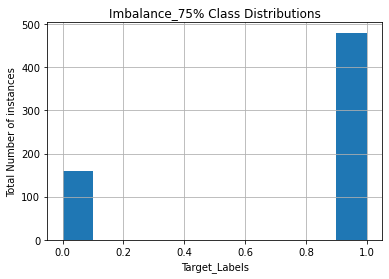

In [79]:
# 75% imbalance target feature
y_75.hist() 
plt.title('Imbalance_75% Class Distributions')
plt.xlabel('Target_Labels')
plt.ylabel('Total Number of instances')
plt.savefig('Imbalance_75% Class Distributions.jpg')

In [80]:
#Training with 75% imbalance surrogate
skf.get_n_splits(X_75, y_75)
score = []
precision = []
recall = []
for train_index, test_index in skf.split(X_75, y_75):
    #print('Train:' , train_index, 'Validation: ', test_index)
    x_train, x_test = X_75.iloc[train_index], X_75.iloc[test_index]
    y_train, y_test = y_75.iloc[train_index], y_75.iloc[test_index]
    rf_clf.fit(x_train, y_train)
    acc = accuracy_score(y_test, rf_clf.predict(x_test))
    precision_s = precision_score(y_test, rf_clf.predict(x_test),average='macro')
    recall_s = recall_score(y_test, rf_clf.predict(x_test))
    score.append(acc)
    precision.append(precision_s)
    recall.append(recall_s)

In [81]:
#Metrics @ 75%
print('Mean Accuracy Score: {}'.format(np.array(score).mean()))
print('Mean Precision Score: {}'.format(np.array(precision).mean()))
print('Mean Recall Score: {}'.format(np.array(recall).mean()))

Mean Accuracy Score: 0.853125
Mean Precision Score: 0.8342363868771037
Mean Recall Score: 0.9458333333333332


In [82]:
X_90, y_90 = make_imbalance(X, y, sampling_strategy={0:64 , 1: 576}, random_state=48)
print(f'Distribution after imbalancing: {Counter(y_90)}')

Distribution after imbalancing: Counter({1: 576, 0: 64})


In [83]:
class0 , class1 = y_90.value_counts(normalize = True)
print(f'Class 0 after imbalance_90%:', round(class0 *100,1) ,'%')
print(f'Class 1 after imbalance_90%:', round(class1 *100,1) ,'%')

Class 0 after imbalance_90%: 90.0 %
Class 1 after imbalance_90%: 10.0 %


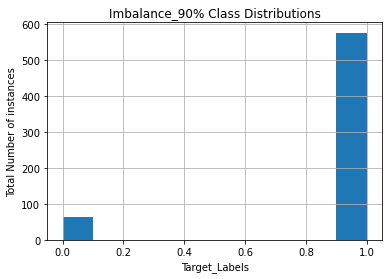

In [84]:
# 90% imbalance target feature plot
y_90.hist() 
plt.title('Imbalance_90% Class Distributions')
plt.xlabel('Target_Labels')
plt.ylabel('Total Number of instances')
plt.savefig('Imbalance_90% Class Distributions.jpg')

In [85]:
#Training with 90% imbalance surrogate
skf.get_n_splits(X_90, y_90)
score = []
precision = []
recall = []
for train_index, test_index in skf.split(X_90, y_90):
    #print('Train:' , train_index, 'Validation: ', test_index)
    x_train, x_test = X_90.iloc[train_index], X_90.iloc[test_index]
    y_train, y_test = y_90.iloc[train_index], y_90.iloc[test_index]
    rf_clf.fit(x_train, y_train)
    acc = accuracy_score(y_test, rf_clf.predict(x_test))
    precision_s = precision_score(y_test, rf_clf.predict(x_test),average='macro')
    recall_s = recall_score(y_test, rf_clf.predict(x_test))
    score.append(acc)
    precision.append(precision_s)
    recall.append(recall_s)

C:\Users\Praveen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Praveen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
#Metrics @ 90%
print('Mean Accuracy Score: {}'.format(np.array(score).mean()))
print('Mean Precision Score: {}'.format(np.array(precision).mean()))
print('Mean Recall Score: {}'.format(np.array(recall).mean()))

Mean Accuracy Score: 0.8984375
Mean Precision Score: 0.6591408127641702
Mean Recall Score: 0.9826678765880217


# Part 3

In [87]:
x_train = []
x_test = []
y_train = []
y_test = []
skf.get_n_splits(X_65, y_65)
for train_index, test_index in skf.split(X_90, y_90):
    #print('Train:' , train_index, 'Validation: ', test_index)
    xtrain, xtest = X_90.iloc[train_index], X_90.iloc[test_index]
    ytrain, ytest = y_90.iloc[train_index], y_90.iloc[test_index]
    x_train.append(xtrain)
    x_test.append(xtest)
    y_train.append(ytrain)
    y_test.append(ytest)

In [88]:
x_train[0].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
7,11.7,0.490,0.49,2.2,0.083,5.0,15.0,1.00000,3.19,0.43,9.2
8,6.8,0.610,0.20,1.8,0.077,11.0,65.0,0.99710,3.54,0.58,9.3
9,7.5,0.755,0.00,1.9,0.084,6.0,12.0,0.99672,3.34,0.49,9.7
10,5.9,0.190,0.21,1.7,0.045,57.0,135.0,0.99341,3.32,0.44,9.5
11,7.5,0.520,0.11,1.5,0.079,11.0,39.0,0.99680,3.42,0.58,9.6


# Part 4

### Elbow Method

In [89]:
wss_score = [[] for col in range(9) for row in range(9)]
for i in range(0,9):
    for j in range(2, 12):
        kmeans=cluster.KMeans(n_clusters=j,init="k-means++")
        kmeans=kmeans.fit(x_train[i])
        wss_iter = kmeans.inertia_
        wss_score[i].append(wss_iter)

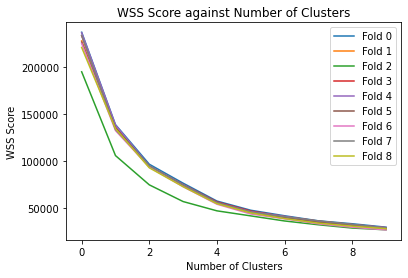

In [90]:
for i in range(0,9):
    plt.plot(wss_score[i], label= 'Fold {}'.format(i))
    plt.xlabel('Number of Clusters')
    plt.ylabel('WSS Score')
    plt.title('WSS Score against Number of Clusters')
    plt.legend()
    plt.savefig('Elbow_plot_wine_quality.jpg')

- 2 clusters identified using Elbow method

### Silhouette method

In [91]:
from sklearn.metrics import silhouette_score

In [92]:
scores_arr = [[] for col in range(9) for row in range(9)]
for i in range(0,9):
    for j in range(2, 12):
        labels=cluster.KMeans(n_clusters=j,init="k-means++",random_state=200).fit(x_train[i]).labels_
        scores = silhouette_score(x_train[i],labels,metric="euclidean",sample_size=1000,random_state=200)
        scores_arr[i].append(scores)

In [93]:
for i in range(0,9):
    max_value = max(scores_arr[i])
    max_index = scores_arr[i].index(max_value)
    print('For Cluster {}, the maximum score is at index: {}'.format(i, max_index))

For Cluster 0, the maximum score is at index: 0
For Cluster 1, the maximum score is at index: 0
For Cluster 2, the maximum score is at index: 0
For Cluster 3, the maximum score is at index: 0
For Cluster 4, the maximum score is at index: 0
For Cluster 5, the maximum score is at index: 0
For Cluster 6, the maximum score is at index: 0
For Cluster 7, the maximum score is at index: 0
For Cluster 8, the maximum score is at index: 0


- The maximum Silhouette score is found at index 0 for all the folds which corresponds to 2 clusters

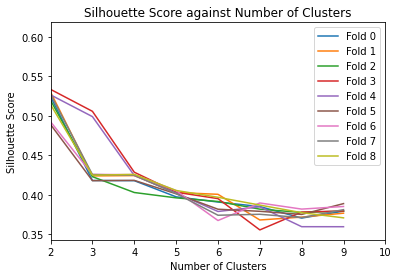

In [94]:
# Visualizing Silhouette scores for the different folds
for i in range(0,9):
    plt.plot(scores_arr[i], label= 'Fold {}'.format(i))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score against Number of Clusters')
    plt.xlim([2, 10])
    plt.legend()
    plt.savefig('Silhouette_plot_wine_quality.jpg')

### K-Means

In [95]:
clusters_arr = [[] for col in range(9) for row in range(len(x_train[1]))]
kmeans = cluster.KMeans(n_clusters=2 ,init="k-means++")
for i in range(0,9):
    kmeans = kmeans.fit(x_train[i])
    clusters = kmeans.labels_
    clusters_arr[i].append(clusters)

In [96]:
dftest = x_train[8]
dftest['pred_labels'] = np.transpose(clusters_arr[8])
dftest['true_labels'] = y_train[8]
dftest.head()

<ipython-input-96-f92b37f6f9c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['pred_labels'] = np.transpose(clusters_arr[8])
<ipython-input-96-f92b37f6f9c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['true_labels'] = y_train[8]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels
0,6.1,0.64,0.02,2.4,0.069,26.0,46.0,0.99358,3.47,0.45,11.0,0,0
1,7.2,0.60,0.04,2.5,0.076,18.0,88.0,0.99745,3.53,0.55,9.5,1,0
2,6.6,0.44,0.15,2.1,0.076,22.0,53.0,0.99570,3.32,0.62,9.3,1,0
3,8.0,0.64,0.22,2.4,0.094,5.0,33.0,0.99612,3.37,0.58,11.0,0,0
4,10.0,0.73,0.43,2.3,0.059,15.0,31.0,0.99660,3.15,0.57,11.0,0,0


In [97]:
dftest1 = dftest[dftest['pred_labels'].isin([1])]
dftest1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels
1,7.2,0.60,0.04,2.5,0.076,18.0,88.0,0.99745,3.53,0.55,9.5,1,0
2,6.6,0.44,0.15,2.1,0.076,22.0,53.0,0.99570,3.32,0.62,9.3,1,0
8,6.8,0.61,0.20,1.8,0.077,11.0,65.0,0.99710,3.54,0.58,9.3,1,0
10,5.9,0.19,0.21,1.7,0.045,57.0,135.0,0.99341,3.32,0.44,9.5,1,0
12,7.3,0.69,0.32,2.2,0.069,35.0,104.0,0.99632,3.33,0.51,9.5,1,0


In [98]:
accuracy_score(dftest1['true_labels'], dftest1['pred_labels'])

0.8106060606060606

In [99]:
dftest1['true_labels'].value_counts() #There are 33 minority labels(belong to cluster 0)

1    107
0     25
Name: true_labels, dtype: int64

In [100]:
dftest_1 = dftest1[dftest1['true_labels'].isin([0])]
dftest_1['true_labels'].value_counts()

0    25
Name: true_labels, dtype: int64

In [101]:
dftest0 = dftest[dftest['pred_labels'].isin([0])]
dftest0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels
0,6.1,0.64,0.02,2.4,0.069,26.0,46.0,0.99358,3.47,0.45,11.0,0,0
3,8.0,0.64,0.22,2.4,0.094,5.0,33.0,0.99612,3.37,0.58,11.0,0,0
4,10.0,0.73,0.43,2.3,0.059,15.0,31.0,0.99660,3.15,0.57,11.0,0,0
5,9.4,0.40,0.47,2.5,0.087,6.0,20.0,0.99772,3.15,0.50,10.5,0,0
6,7.5,0.58,0.20,2.0,0.073,34.0,44.0,0.99494,3.10,0.43,9.3,0,0


In [102]:
dftest_0 = dftest0[dftest0['true_labels'].isin([1])]
dftest_0['true_labels'].value_counts()

1    411
Name: true_labels, dtype: int64

In [103]:
#Combining the datasets
df_new = pd.concat([dftest_0, dftest_1], axis=0)
df_new.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels
64,7.4,0.29,0.38,1.7,0.062,9.0,30.0,0.99680,3.41,0.53,9.5,0,1
65,10.5,0.28,0.51,1.7,0.080,10.0,24.0,0.99820,3.20,0.89,9.4,0,1
66,10.1,0.38,0.50,2.4,0.104,6.0,13.0,0.99643,3.22,0.65,11.6,0,1
67,8.8,0.24,0.35,1.7,0.055,13.0,27.0,0.99394,3.14,0.59,11.3,0,1
68,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.99460,3.39,0.47,10.0,0,1


In [104]:
df_new['true_labels'].value_counts()

1    411
0     25
Name: true_labels, dtype: int64

In [105]:
#Training Random forest classifier
del df_new['pred_labels']

In [106]:
df_new.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,true_labels
64,7.4,0.29,0.38,1.7,0.062,9.0,30.0,0.99680,3.41,0.53,9.5,1
65,10.5,0.28,0.51,1.7,0.080,10.0,24.0,0.99820,3.20,0.89,9.4,1
66,10.1,0.38,0.50,2.4,0.104,6.0,13.0,0.99643,3.22,0.65,11.6,1
67,8.8,0.24,0.35,1.7,0.055,13.0,27.0,0.99394,3.14,0.59,11.3,1
68,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.99460,3.39,0.47,10.0,1


In [107]:
x = df_new.loc[:, df_new.columns != 'true_labels']
y = df_new['true_labels']

In [108]:
rf_clf = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42)
rf_clf.fit(x, y)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [109]:
print('RF Train accuracy: {}'.format(accuracy_score(y, rf_clf.predict(x))))

RF Train accuracy: 1.0


In [110]:
## Assigning clusters to unseen fold
kmeans = cluster.KMeans(n_clusters=2 ,init="k-means++")
kmeans = kmeans.fit(x_train[8])
clusters = kmeans.labels_
clusters

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,

In [111]:
accuracy_score(y_train[8],clusters)

0.7569444444444444

In [112]:
df_x = x_train[8]
df_x['labels'] = clusters
print(df_x.shape)
df_x.head()

(576, 14)


<ipython-input-112-840ddb461245>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['labels'] = clusters


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels,labels
0,6.1,0.64,0.02,2.4,0.069,26.0,46.0,0.99358,3.47,0.45,11.0,0,0,1
1,7.2,0.60,0.04,2.5,0.076,18.0,88.0,0.99745,3.53,0.55,9.5,1,0,0
2,6.6,0.44,0.15,2.1,0.076,22.0,53.0,0.99570,3.32,0.62,9.3,1,0,0
3,8.0,0.64,0.22,2.4,0.094,5.0,33.0,0.99612,3.37,0.58,11.0,0,0,1
4,10.0,0.73,0.43,2.3,0.059,15.0,31.0,0.99660,3.15,0.57,11.0,0,0,1


In [113]:
arr = []
for i in range(len(df_x)):
    res = df_x['labels'].iloc[i] == df_x['true_labels'].iloc[i]
    arr.append(res)
arr

[False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 Tr

In [114]:
df_x['bool'] = arr
df_x = df_x[df_x['bool'].isin([False])]
df_x.shape

<ipython-input-114-9f1c0fa92ac7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['bool'] = arr


(140, 15)

In [115]:
df_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pred_labels,true_labels,labels,bool
0,6.1,0.64,0.02,2.4,0.069,26.0,46.0,0.99358,3.47,0.45,11.0,0,0,1,False
3,8.0,0.64,0.22,2.4,0.094,5.0,33.0,0.99612,3.37,0.58,11.0,0,0,1,False
4,10.0,0.73,0.43,2.3,0.059,15.0,31.0,0.99660,3.15,0.57,11.0,0,0,1,False
5,9.4,0.40,0.47,2.5,0.087,6.0,20.0,0.99772,3.15,0.50,10.5,0,0,1,False
6,7.5,0.58,0.20,2.0,0.073,34.0,44.0,0.99494,3.10,0.43,9.3,0,0,1,False


In [116]:
del df_x['pred_labels']
del df_x['labels']
del df_x['bool']

In [117]:
## Random Forest
x = df_x.loc[:, df_x.columns != 'true_labels']
y = df_x['true_labels']
accuracy_score(y, rf_clf.predict(x))

0.11428571428571428